# Import Library

In [85]:
#Import Library
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import shutil

# Data Preprocessing

In [86]:
# read train data and test data from directory
# dir_dataset = "E:\ilmu\Kuliah\sem 7 dan 8\Tugas Akhir\dataset\\Network Attack Simulation\Dataset of DoS Attack Simulation"
dir_dataset = 'TRAIN DATA AND TEST DATA DIRECTORY'

df_train = pd.read_csv(dir_dataset + '\\train.csv')
df_test = pd.read_csv(dir_dataset + '\\test.csv')

In [87]:
#  load dataset into train data, train labels, test data and test labels
def load_train_test(df_train, df_test):
    train_x, train_y = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
    return train_x, train_y, test_x, test_y

In [88]:
# call function load_train_test()
train_x, train_y, test_x, test_y = load_train_test(df_train, df_test)

In [89]:
# define dimension data
dim_data = train_x.shape

In [92]:
# scaling train data and test data
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# Create Model

In [93]:
# Custom layer Densetranspose for NDAE
# NDAE doesn't have decoder 
# NDAE using current layer encoder as decoder 
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'dense': self.dense,
          'activation': self.activation
      })
      return config
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
    self.W = tf.transpose(self.dense.weights[0]) 
    super().build(batch_input_shape)
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.dense.input_shape[-1])
  def call(self, inputs):
    z = tf.matmul(inputs, self.W)
    return self.activation(z + self.biases)

In [94]:
# construct first autoencoder
num_hidden = (dim_data[1], 14, 28, 28)

Dense_11 = Dense(units=num_hidden[1], activation='sigmoid')
Dense_12 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_13 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_1 = Input(shape=(num_hidden[0],))

#Encoder
encoded_11 = Dense_11(inputs_1)
encoded_12 = Dense_12(encoded_11)
encoded_13 = Dense_13(encoded_12)

#Decoder
decoded_11 = DenseTranspose(Dense_13, activation='sigmoid')(encoded_13)
decoded_12 = DenseTranspose(Dense_12, activation='sigmoid')(decoded_11)
outputs_1 = DenseTranspose(Dense_11, activation='sigmoid')(decoded_12)

AE_1=Model(inputs_1, outputs_1, name='AE_1')
Encoder_1=Model(inputs_1, decoded_12, name ='Encoder_1')

In [95]:
# construct second autoencoder 
Dense_21 = Dense(units=num_hidden[2], activation='sigmoid')
Dense_22 = Dense(units=num_hidden[3], activation='sigmoid')

inputs_2 = Input(shape=(num_hidden[1],))

#Encoder
encoded_21 = Dense_21(inputs_2)
encoded_22 = Dense_22(encoded_21)

#Decoder
decoded_21 = DenseTranspose(Dense_22, activation='sigmoid')(encoded_22)
outputs_2 = DenseTranspose(Dense_21, activation='sigmoid')(decoded_21)

AE_2=Model(inputs_2, outputs_2, name='AE_2')
Encoder_2=Model(inputs_2, decoded_21, name='Encoder_2')

In [96]:
#  construct random forest classifier
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)

In [97]:
AE_1.summary()

Model: "AE_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_10 (Dense)            (None, 14)                1092      
                                                                 
 dense_11 (Dense)            (None, 28)                420       
                                                                 
 dense_12 (Dense)            (None, 28)                812       
                                                                 
 dense_transpose_10 (DenseTr  (None, 28)               840       
 anspose)                                                        
                                                                 
 dense_transpose_11 (DenseTr  (None, 14)               434       
 anspose)                                                     

In [98]:
AE_2.summary()

Model: "AE_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_13 (Dense)            (None, 28)                420       
                                                                 
 dense_14 (Dense)            (None, 28)                812       
                                                                 
 dense_transpose_13 (DenseTr  (None, 28)               840       
 anspose)                                                        
                                                                 
 dense_transpose_14 (DenseTr  (None, 14)               434       
 anspose)                                                        
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable para

In [99]:
Encoder_1.summary()

Model: "Encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_10 (Dense)            (None, 14)                1092      
                                                                 
 dense_11 (Dense)            (None, 28)                420       
                                                                 
 dense_12 (Dense)            (None, 28)                812       
                                                                 
 dense_transpose_10 (DenseTr  (None, 28)               840       
 anspose)                                                        
                                                                 
 dense_transpose_11 (DenseTr  (None, 14)               434       
 anspose)                                                

In [100]:
Encoder_2.summary()

Model: "Encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_13 (Dense)            (None, 28)                420       
                                                                 
 dense_14 (Dense)            (None, 28)                812       
                                                                 
 dense_transpose_13 (DenseTr  (None, 28)               840       
 anspose)                                                        
                                                                 
Total params: 1,260
Trainable params: 1,260
Non-trainable params: 0
_________________________________________________________________


In [111]:
# training first autoencoder
AE_1.compile(optimizer='rmsprop', loss= 'mse')
AE_1.fit(train_x,train_x,epochs=10,batch_size=16,shuffle=True)

Epoch 1/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8577
Epoch 2/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8572
Epoch 3/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8571
Epoch 4/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8571
Epoch 5/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 6/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 7/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 8/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 9/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 10/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570


In [112]:
# encode input data
AE_1_encoded_train = Encoder_1.predict(train_x)
AE_1_encoded_test = Encoder_1.predict(test_x)

357/357 [==============================] - 0s 1ms/step


In [113]:
# training second autoencoder with encoded data
AE_2.compile(optimizer='rmsprop', loss= 'mse')
AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=10,batch_size=16,shuffle=True)

Epoch 1/10
2852/2852 [==============================] - 5s 1ms/step - loss: 0.0157
Epoch 2/10
2852/2852 [==============================] - 4s 1ms/step - loss: 0.0014
Epoch 3/10
2852/2852 [==============================] - 4s 1ms/step - loss: 9.4045e-04
Epoch 4/10
2852/2852 [==============================] - 4s 1ms/step - loss: 8.7728e-04
Epoch 5/10
2852/2852 [==============================] - 4s 2ms/step - loss: 8.3686e-04
Epoch 6/10
2852/2852 [==============================] - 4s 1ms/step - loss: 8.0431e-04
Epoch 7/10
2852/2852 [==============================] - 4s 1ms/step - loss: 7.9115e-04
Epoch 8/10
2852/2852 [==============================] - 4s 2ms/step - loss: 7.7733e-04
Epoch 9/10
2852/2852 [==============================] - 4s 1ms/step - loss: 7.7121e-04
Epoch 10/10
2852/2852 [==============================] - 4s 2ms/step - loss: 7.6932e-04


In [114]:
# encoded input data
AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

357/357 [==============================] - 0s 1ms/step


In [115]:
# training random forest and evaluate accuracy
rfc.fit(AE_2_encoded_train, train_y)
rfc.score(AE_2_encoded_test, test_y)

0.9357468443197756

# Evaluation Metric
Evaluation metrics are used to assess the performance of a model. The metrics used include precision, recall, F1 score, accuracy, and ROC curve.

In [116]:
testResult = rfc.predict(AE_2_encoded_test)

In [ ]:
print(classification_report(test_y, testResult))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=test_y, y_pred=testResult)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize = (12, 8))

fpr, tpr, _ = roc_curve(test_y, testResult)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# 1. Hyperparameter Testing
The hyperparameters varied in this experiment are the batch size and the choice of optimizer. This testing is conducted to find the most optimal hyperparameters based on the highest accuracy. The code used is the same as before

[Adam, RMSprop]

[16, 32, 64, 128, 256]

In [118]:
def hyperparameter_testing(batch_size, opt, results):
    print('==============================')
    print('batch_size =', batch_size)
    print('optimizer =', opt)
    AE_1.compile(optimizer=opt, loss= 'mse')
    AE_1.fit(train_x,train_x,epochs=10,batch_size=batch_size)

    AE_1_encoded_train = Encoder_1.predict(train_x)
    AE_1_encoded_test = Encoder_1.predict(test_x)

    AE_2.compile(optimizer=opt, loss= 'mse')
    AE_2.fit(AE_1_encoded_train,AE_1_encoded_train,epochs=10,batch_size=batch_size)

    AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
    AE_2_encoded_test = Encoder_2.predict(AE_1_encoded_test)

    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)
    rfc.fit(AE_2_encoded_train, train_y)
    acc = rfc.score(AE_2_encoded_test, test_y)
    results.append([acc, opt, batch_size])
    print(rfc.score(AE_2_encoded_test, test_y))

    print()

    testResult = rfc.predict(AE_2_encoded_test)
    print(classification_report(test_y, testResult))

In [119]:
optlist = ['rmsprop', 'adam']
batch_size_list = [16, 32, 64, 128, 256]
results = []
for opt in optlist:
    for batch_size in batch_size_list: 
        hyperparameter_testing(batch_size, opt, results)

batch_size = 16
optimizer = rmsprop
Epoch 1/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 2/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 3/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 4/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 5/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 6/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 7/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 8/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 9/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.8570
Epoch 10/10
357/357 [==============================] - 0s 1ms/step
Epoch 1/10
2852/2852 [==============================] - 5s 2ms/step - loss: 0.0013
Epoch 2/10
2852/2852 [==============================] - 4s 2ms/step

713/713 [==============================] - 3s 3ms/step - loss: 0.8570
Epoch 2/10
713/713 [==============================] - 2s 3ms/step - loss: 0.8570
Epoch 3/10
713/713 [==============================] - 2s 3ms/step - loss: 0.8570
Epoch 4/10
713/713 [==============================] - 3s 4ms/step - loss: 0.8570
Epoch 5/10
713/713 [==============================] - 2s 3ms/step - loss: 0.8570
Epoch 6/10
713/713 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 7/10
713/713 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 8/10
713/713 [==============================] - 2s 3ms/step - loss: 0.8570
Epoch 9/10
713/713 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 10/10
357/357 [==============================] - 0s 1ms/step
Epoch 1/10
713/713 [==============================] - 2s 2ms/step - loss: 7.9036e-04
Epoch 2/10
713/713 [==============================] - 1s 2ms/step - loss: 7.9012e-04
Epoch 3/10
713/713 [=========================

In [120]:
maxacc = 0
chosen_hyperparameter = None
for result in results:
    acc = result[0]
    if maxacc < acc:
        maxacc = acc
        chosen_hyperparameter = result.copy()

## Result of Hyperparameter Testing

In [121]:
for r in results:
    print(f'accuracy: {r[0]} - optimizer: {r[1]} - batch size = {r[2]}')

accuracy: 0.9340813464235624 - optimizer: rmsprop - batch size = 16
accuracy: 0.9345196353436185 - optimizer: rmsprop - batch size = 32
accuracy: 0.9348702664796634 - optimizer: rmsprop - batch size = 64
accuracy: 0.9347826086956522 - optimizer: rmsprop - batch size = 128
accuracy: 0.9348702664796634 - optimizer: rmsprop - batch size = 256
accuracy: 0.9400420757363254 - optimizer: adam - batch size = 16
accuracy: 0.9421458625525947 - optimizer: adam - batch size = 32
accuracy: 0.9410063113604488 - optimizer: adam - batch size = 64
accuracy: 0.9413569424964937 - optimizer: adam - batch size = 128
accuracy: 0.9412692847124825 - optimizer: adam - batch size = 256


# 2. Model Validation Testing
Testing is performed using K-Fold validation with the most optimal hyperparameters. The results of this testing include the precision, recall, accuracy, F1-score, ROC curve, and the training time for each iteration of the model.

In [123]:
def convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list ):
    print('==============================')
    print('optimizer =', opt)
    print('batch size =', batch_size)
    print('KFold = 10')
    kfold = KFold(n_splits=10, shuffle=True)
    AE_1.compile(optimizer=opt, loss= 'mse')
    AE_2.compile(optimizer=opt, loss= 'mse')
    total_time1 = 0
    total_time2 = 0
    total_acc = 0
    i = 1
    
    train_x, train_y, _, _ = load_train_test(df_train, df_test)
    for train_idx, valid_idx in kfold.split(train_x):
        print('\nCurrent KFold = ', i)
        Xtrain, Xvalid = train_x.iloc[train_idx], train_x.iloc[valid_idx]
        Ytrain, Yvalid = train_y.iloc[train_idx], train_y.iloc[valid_idx]
        #scaling
        scaler_kfold = StandardScaler()
        scaler_kfold.fit(Xtrain)
        Xtrain_scaled = scaler_kfold.transform(Xtrain)
        Xvalid_scaled = scaler_kfold.transform(Xvalid)
        # train AE1
        time_before_training_AE_1 = datetime.now()
        AE_1.fit(Xtrain_scaled, Xtrain_scaled, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_1 = datetime.now()
        delta_time_AE_1 = time_after_training_AE_1 - time_before_training_AE_1
        # encoder 1
        AE_1_encoded_train = Encoder_1.predict(Xtrain_scaled)
        AE_1_encoded_valid = Encoder_1.predict(Xvalid_scaled)

        # train AE2
        time_before_training_AE_2 = datetime.now()
        AE_2.fit(AE_1_encoded_train, AE_1_encoded_train, epochs=epochs, batch_size=batch_size)
        time_after_training_AE_2 = datetime.now()
        delta_time_AE_2 = time_after_training_AE_2 - time_before_training_AE_2
        
        # encoder 2
        AE_2_encoded_train = Encoder_2.predict(AE_1_encoded_train)
        AE_2_encoded_valid = Encoder_2.predict(AE_1_encoded_valid)
        
        #training RF
        rfc.fit(AE_2_encoded_train, Ytrain)
        
        print(time_before_training_AE_1)
        print(time_after_training_AE_1)
        print('time taken for training 1st autoencoder', delta_time_AE_1.total_seconds())
        print()
        print(time_before_training_AE_2)
        print(time_after_training_AE_2)
        print('time taken for training 2nd autoencoder', delta_time_AE_2.total_seconds())
        print()
        print('total time =', delta_time_AE_1.total_seconds() + delta_time_AE_2.total_seconds())
        
        total_time1 += delta_time_AE_1.total_seconds()
        total_time2 += delta_time_AE_2.total_seconds()
        time_list.append([delta_time_AE_1.total_seconds(), delta_time_AE_2.total_seconds()])
        
        print('Data Train')
        trainResult = rfc.predict(AE_2_encoded_train)
        print(rfc.score(AE_2_encoded_train, Ytrain))
        print(classification_report(Ytrain, trainResult))
        
        print('Data Valid')
        validResult = rfc.predict(AE_2_encoded_valid)
        valid_acc = rfc.score(AE_2_encoded_valid, Yvalid)
        total_acc += valid_acc
        acc_list.append(valid_acc)
        print(valid_acc)
        print(classification_report(Yvalid, validResult))
            
        print()
        
        fpr, tpr, _ = roc_curve(Yvalid, validResult)
        roc_auc = auc(fpr, tpr)
        roc_list.append([fpr, tpr, roc_auc])
        print()
        i+=1
        
    avg_time_AE_1 = total_time1 / 10 
    avg_time_AE_2 = total_time2 / 10
    avg_total_val_acc = total_acc / 10
    print('Average training time for AE_1:', avg_time_AE_1, 'seconds')
    print('Average training time for AE_2:', avg_time_AE_2, 'seconds')
    print('Average accuracy of 10 folds :', avg_total_val_acc)

In [124]:
epochs = 10
opt = chosen_hyperparameter[1]
batch_size = chosen_hyperparameter[2]
roc_list = []
time_list = []
acc_list = []
convergence_time_test(epochs, opt, batch_size, roc_list, time_list, acc_list)

optimizer = adam
batch size = 32
KFold = 10

Current KFold =  1
Epoch 1/10
1284/1284 [==============================] - 3s 2ms/step - loss: 0.8570
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 3/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 4/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 5/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 6/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 7/10
1284/1284 [==============================] - 3s 2ms/step - loss: 0.8570
Epoch 8/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 9/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 10/10
143/143 [==============================] - 0s 1ms/step
Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8989e-04
Epoch 2/10
1284/1284 [=============

Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 3/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 4/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 5/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 6/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 7/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 8/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 9/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 10/10
143/143 [==============================] - 0s 1ms/step
Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8760e-04
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8738e-04
Epoch 3/10
1

Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 3/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 4/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 5/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 6/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 7/10
1284/1284 [==============================] - 3s 2ms/step - loss: 0.8570
Epoch 8/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 9/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 10/10
143/143 [==============================] - 0s 1ms/step
Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8742e-04
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8710e-04
Epoch 3/10
1

Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 3/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 4/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 5/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 6/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 7/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 8/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 9/10
1284/1284 [==============================] - 2s 2ms/step - loss: 0.8570
Epoch 10/10
143/143 [==============================] - 0s 1ms/step
Epoch 1/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8808e-04
Epoch 2/10
1284/1284 [==============================] - 2s 2ms/step - loss: 7.8781e-04
Epoch 3/10
1

## Result of Validation Model

In [125]:
for i,acc in enumerate(acc_list):
    print(f'fold {i+1} - accuracy: {acc} - time AE1: {time_list[i][0]} - time AE2: {time_list[i][1]}')

fold 1 - accuracy: 0.9408284023668639 - time AE1: 23.388777 - time AE2: 22.996967
fold 2 - accuracy: 0.9474030243261012 - time AE1: 24.120956 - time AE2: 20.814476
fold 3 - accuracy: 0.9524435678281832 - time AE1: 22.842018 - time AE2: 20.366065
fold 4 - accuracy: 0.9498137190444883 - time AE1: 22.360963 - time AE2: 21.52699
fold 5 - accuracy: 0.9482796405873329 - time AE1: 23.37778 - time AE2: 19.978445
fold 6 - accuracy: 0.9452114836730221 - time AE1: 23.751258 - time AE2: 20.292986
fold 7 - accuracy: 0.9458689458689459 - time AE1: 23.083583 - time AE2: 20.28331
fold 8 - accuracy: 0.9419241726934034 - time AE1: 23.423366 - time AE2: 20.098001
fold 9 - accuracy: 0.9491451117930733 - time AE1: 22.755975 - time AE2: 20.257136
fold 10 - accuracy: 0.9458570802279702 - time AE1: 22.518325 - time AE2: 19.963171


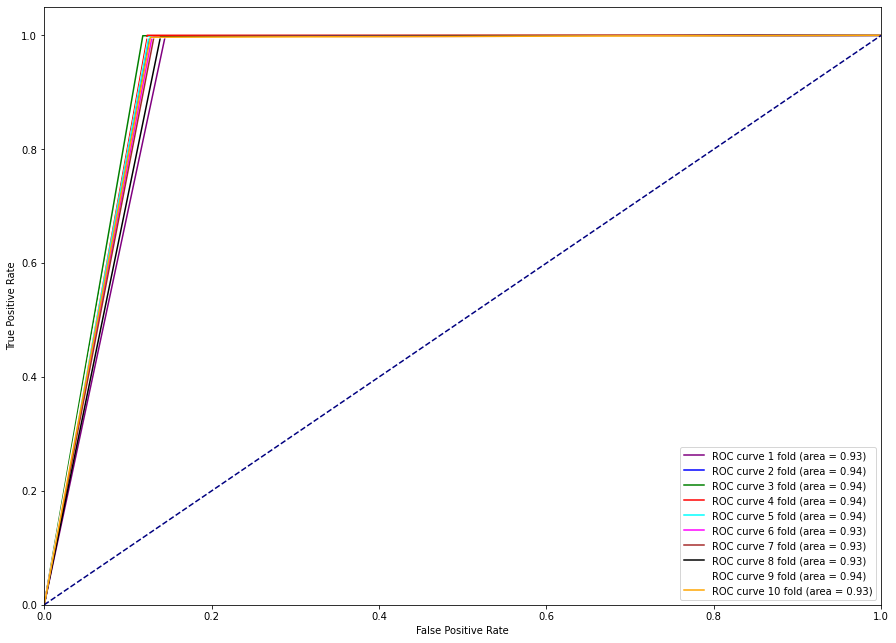

In [126]:
plt.figure(figsize = (15, 11))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'brown', 'black', 'white', 'orange', 'purple']

for i in range(10):        
    plt.plot(roc_list[i][0], roc_list[i][1], color=colors[i-1], label=f'ROC curve {i+1} fold (area = %0.2f)' % roc_list[i][2])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [127]:
for i,roc in enumerate(roc_list):
    print(f'ROC curve {i+1} fold (area = {roc[2]}) ')

ROC curve 1 fold (area = 0.9271293939566734) 
ROC curve 2 fold (area = 0.9359200062078556) 
ROC curve 3 fold (area = 0.9407306603159992) 
ROC curve 4 fold (area = 0.9385069817400644) 
ROC curve 5 fold (area = 0.9361847529092665) 
ROC curve 6 fold (area = 0.9341137317389072) 
ROC curve 7 fold (area = 0.9328332149289013) 
ROC curve 8 fold (area = 0.9292396959070194) 
ROC curve 9 fold (area = 0.9372097384474524) 
ROC curve 10 fold (area = 0.9348918104933264) 
